# Air Quality Data Analysis

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Pandas version:', pd.__version__) # 2.2.3
print('Numpy version:', np.__version__) # 1.26.4
print('Seaborn version:', sns.__version__) # 0.13.2

Pandas version: 2.2.3
Numpy version: 1.26.4
Seaborn version: 0.13.2


## Loading the dataset

In [25]:
df = pd.read_csv('./data/cleaned_data.csv')
df.head()

,Date,Latitude,Longitude,PM1,PM2.5,PM10,NO2,Sensor_ID
0,2021-01-12,"51,4568","5,4383",12.57,14.43,18.98,7.0,I07
1,2021-01-13,"51,4568","5,4383",2.95,4.30,9.31,18.0,I07
2,2021-01-14,"51,4567","5,4382",7.14,9.92,19.15,35.0,I07
3,2021-01-15,"51,4567","5,4382",6.45,8.39,14.20,28.0,I07
4,2021-01-16,"51,4567","5,4382",15.00,16.44,20.35,31.0,I07


In [26]:
df['Latitude'] = df['Latitude'].astype(str).str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].astype(str).str.replace(',', '.').astype(float)

df['Date'] = pd.to_datetime(df['Date'])


In [27]:
df.dtypes

Date         datetime64[ns]
Latitude            float64
Longitude           float64
PM1                 float64
PM2.5               float64
PM10                float64
NO2                 float64
Sensor_ID            object
dtype: object

First I will visualise the locations of the sensors that have been chosen on a map of Eindhoven. This way we can easily see the type of area the sensor is located in.

In [28]:
eindhoven_coords = [51.4416, 5.4697]

In [29]:
sensor_coordinates = df.groupby('Sensor_ID')[['Latitude', 'Longitude']].apply(lambda group: group.mode().iloc[0])

eindhoven_map = folium.Map(location=eindhoven_coords, zoom_start=12, scrollWheelZoom=False)

for sensor_id, row in sensor_coordinates.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        icon=folium.DivIcon(html=f"""
            <div style="
                font-size: 10px;
                color: white;
                background: green;
                border-radius: 50%;
                text-align: center;
                width: 30px;
                height: 30px;
                display: flex;
                justify-content: center;
                align-items: center;
                border: 1px solid black;">
                {sensor_id}
            </div>
        """),
    ).add_to(eindhoven_map)

eindhoven_map

Next I am gonna display the values of the sensors on the map, to see the which areas are the most polluted compared to the other sensors. Since the UHI data is an average of the months June, Juli and August of 2022 we will also take the average of the values of the sensors for these months.

In [30]:
start_date = '2022-06-01'
end_date = '2022-08-31'

df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

average_values = (
    df_filtered.groupby('Sensor_ID')[['PM1', 'PM2.5', 'PM10', 'NO2']]
    .mean()
    .reset_index()
)

mode_coords = df_filtered.groupby('Sensor_ID')[['Latitude', 'Longitude']].agg(lambda x: x.mode()[0]).reset_index()

average_values = average_values.merge(mode_coords, on='Sensor_ID', how='left')

average_values
df_average = pd.DataFrame(average_values)



In [31]:
import folium
import pandas as pd
from folium import FeatureGroup
from matplotlib import colors, colormaps

def normalise_values(values, cmap_name='coolwarm'):
    cmap = colormaps.get_cmap(cmap_name)
    norm = colors.Normalize(vmin=min(values), vmax=max(values))
    return [colors.rgb2hex(cmap(norm(value))) for value in values]

def add_parameter_layer(map_object, df, parameter, layer_name):
    valid_rows = df[df[parameter].notnull()]
    if valid_rows.empty:
        print(f"No data available for {parameter}. Skipping layer.")
        return
    
    values = valid_rows[parameter].tolist()
    colour_map = normalise_values(values)
    
    layer = FeatureGroup(name=layer_name)
    
    for index, row in valid_rows.iterrows():
        value = row[parameter]
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            icon=folium.DivIcon(html=f"""
                <div style="
                    font-size: 12px;
                    color: black;
                    text-align: center;
                    background-color: {colour_map[index % len(colour_map)]};
                    border-radius: 50%;
                    text-align: center;
                    width: 40px;
                    height: 40px;
                    display: flex;
                    justify-content: center;
                    align-items: center;
                    border: 1px solid black;">
                    {value:.2f}
                </div>
            """),
            popup=folium.Popup(f"Sensor: {row['Sensor_ID']}<br>{parameter}: {value:.2f}"),
            tooltip=f"Sensor: {row['Sensor_ID']}<br>{parameter}"
        ).add_to(layer)
    
    map_object.add_child(layer)
    
    return layer

eindhoven_map = folium.Map(location=eindhoven_coords, zoom_start=13, scrollWheelZoom=False)

layers = {
    'PM1': add_parameter_layer(eindhoven_map, average_values, 'PM1', 'PM1 Levels'),
    'PM2.5': add_parameter_layer(eindhoven_map, average_values, 'PM2.5', 'PM2.5 Levels'),
    'PM10': add_parameter_layer(eindhoven_map, average_values, 'PM10', 'PM10 Levels'),
    'NO2': add_parameter_layer(eindhoven_map, average_values, 'NO2', 'NO2 Levels')
}

folium.LayerControl().add_to(eindhoven_map)

eindhoven_map


This interactive plot shows the values of the different pollutants over the timespan of the dataset. The sensors and pollutants can be selected using the dropbox.

In [32]:
def plot_interactive(sensor, pollutant):
    filtered_df = df[df['Sensor_ID'] == sensor]
    fig = px.line(
        filtered_df,
        x='Date',
        y=pollutant,
        title=f'{pollutant} Levels for Sensor {sensor}',
        labels={'Date': 'Date', pollutant: 'Value'}
    )
    fig.update_traces(mode="markers+lines", hovertemplate="Date: %{x}<br>Value: %{y}")
    fig.show()

pollutants = ['PM1', 'PM2.5', 'PM10', 'NO2']
sensors = df['Sensor_ID'].unique()

interact(plot_interactive, sensor=sensors, pollutant=pollutants)


interactive(children=(Dropdown(description='sensor', options=('I07', 'I12', 'I17', 'I19', 'I30', 'I36', 'I37')…

<function __main__.plot_interactive(sensor, pollutant)>

### UHI Values
Next I will see if there is a correlation between the PM10 and NO<sub>2</sub> values and the UHI temperature values. The UHI temperature values are obtained from <a href='https://www.atlasleefomgeving.nl/kaarten?config=3ef897de-127f-471a-959b-93b7597de188&gm-x=150000&gm-y=460000&gm-z=3&gm-b=1544180834512,true,1;1578053360170,true,1&activateOnStart=info&deactivateOnStart=layercollection'>this map</a> and are taken by selecting the coordinates of the sensors.

In [33]:
mode_coords

,Sensor_ID,Latitude,Longitude
0,I07,51.4568,5.4383
1,I12,51.4416,5.4714
2,I17,51.4136,5.4707
3,I19,51.4332,5.5198
4,I30,51.4375,5.4518
5,I36,51.4387,5.4817
6,I37,51.4686,5.4723


In [34]:
sensor_ids = df['Sensor_ID'].unique()
values = [0.25, 2.37, 0.46, 1.05, 2.13, 2.31, 1.78]

uhi_temperatures = {f'{sensor}': value for sensor, value in zip(sensor_ids, values)}

In [35]:
df_average

,Sensor_ID,PM1,PM2.5,PM10,NO2,Latitude,Longitude
0,I07,4.290000,5.312500,10.531304,18.554348,51.4568,5.4383
1,I12,7.587500,9.175588,16.493971,11.955882,51.4416,5.4714
2,I17,6.769130,8.295000,14.146739,21.413043,51.4136,5.4707
3,I19,6.910778,8.591333,17.882556,22.088889,51.4332,5.5198
4,I30,6.484778,8.196333,17.676222,17.433333,51.4375,5.4518
5,I36,8.633371,10.531573,19.163034,20.449438,51.4387,5.4817
6,I37,10.433696,11.966739,20.024022,18.978261,51.4686,5.4723


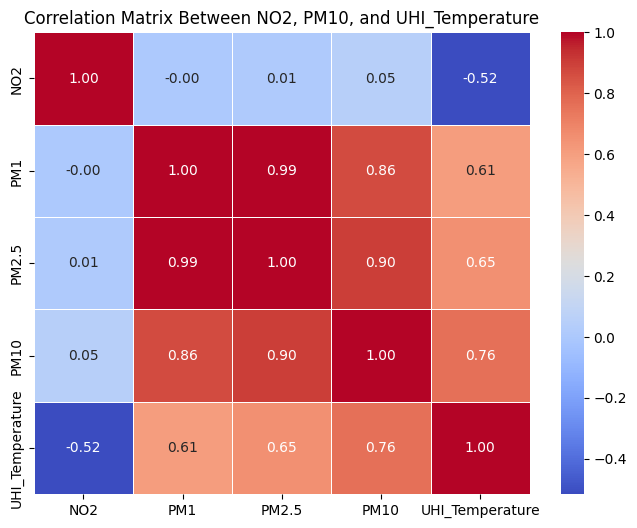

In [36]:
df_uhi = pd.DataFrame(list(uhi_temperatures.items()), columns=['Sensor_ID', 'UHI_Temperature'])
df_corr = pd.merge(df_average, df_uhi, on='Sensor_ID', how='left')

correlation_matrix = df_corr[['NO2', 'PM1', 'PM2.5', 'PM10', 'UHI_Temperature']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between NO2, PM10, and UHI_Temperature")
plt.show()

This heatmap shows there is quite a strong positive correlation between the PM10 values and the UHI temperature increase. There is also a negative correlation between the NO<sub>2</sub> value and the UHI Temperature. However, this might be a coincidence and we would need more data from more sensors to draw some actual conclusions about the influence of PM10 values on the UHI temperature. We also need to look at other data sets, like the pavements, vegetation and energy consumption.

### Weather Data
Next I will try to see if there is a correlation between the PM10 and NO<sub>2</sub> values and the general temperature in Eindhoven. For this I will load the weather dataset.

In [37]:
df_weather = pd.read_csv('./data/eindhoven_weather_2022.csv')
df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Eindhoven,2022-01-01,14.0,11.7,12.6,14.0,11.7,12.6,10.1,85.1,0.000,0,0.00,NaN,0.0,0.0,38.9,17.8,194.4,1022.3,96.0,29.3,29.0,2.5,1,NaN,2022-01-01T08:43:28,2022-01-01T16:40:00,0.95,Overcast,Cloudy skies throughout the day.,cloudy,"06350099999,06464099999,06375099999,0647909999..."
1,Eindhoven,2022-01-02,13.6,10.9,11.9,13.6,10.9,11.9,8.8,81.5,2.850,100,54.17,rain,0.0,0.0,54.2,35.4,218.4,1013.3,96.9,30.1,22.6,2.0,1,NaN,2022-01-02T08:43:21,2022-01-02T16:41:05,0.00,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"D0088,06375099999,06479099999,06377099999,0637..."
2,Eindhoven,2022-01-03,11.1,8.7,9.9,11.1,5.8,8.4,7.2,83.5,1.253,100,16.67,rain,0.0,0.0,61.0,32.2,227.7,1009.8,95.1,24.3,17.6,1.5,1,NaN,2022-01-03T08:43:10,2022-01-03T16:42:12,0.02,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"06464099999,06375099999,06479099999,0637709999..."
3,Eindhoven,2022-01-04,8.6,4.2,7.0,6.1,1.5,4.5,5.7,91.5,3.279,100,45.83,rain,0.0,0.0,36.2,23.4,233.3,998.7,99.6,21.3,8.7,0.7,0,NaN,2022-01-04T08:42:56,2022-01-04T16:43:21,0.06,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"06375099999,06479099999,06377099999,E5087,0637..."
4,Eindhoven,2022-01-05,6.0,1.2,3.8,2.2,-3.4,-0.1,1.6,85.4,3.128,100,58.33,rain,0.0,0.0,50.4,31.4,252.7,1006.8,80.6,18.7,19.7,1.7,1,NaN,2022-01-05T08:42:38,2022-01-05T16:44:34,0.09,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"06464099999,06375099999,06479099999,0637709999..."


In [49]:
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

df_weather_filtered = df_weather[(df_weather['datetime'] >= start_date) & (df_weather['datetime'] <= end_date)].reset_index(drop=True)
df_weather_filtered = df_weather_filtered[['datetime', 'temp']]

df_combined = pd.merge(df_weather_filtered, df_filtered, left_on='datetime', right_on='Date', how='left')

df_combined = df_combined.drop(columns=['datetime']).reset_index(drop=True)
df_combined = df_combined[['Date', 'Sensor_ID', 'Latitude', 'Longitude', 'PM1', 'PM2.5', 'PM10', 'NO2', 'temp']]

df_combined.head()


,Date,Sensor_ID,Latitude,Longitude,PM1,PM2.5,PM10,NO2,temp
0,2022-06-01,I07,51.4568,5.4381,4.62,5.45,9.42,27.0,12.2
1,2022-06-01,I12,51.4413,5.4715,4.89,6.26,10.48,16.0,12.2
2,2022-06-01,I17,51.4136,5.4706,8.25,9.50,14.33,25.0,12.2
3,2022-06-01,I19,51.4331,5.5197,5.59,6.56,10.59,39.0,12.2
4,2022-06-01,I30,51.4375,5.4517,5.49,6.49,9.71,3.0,12.2


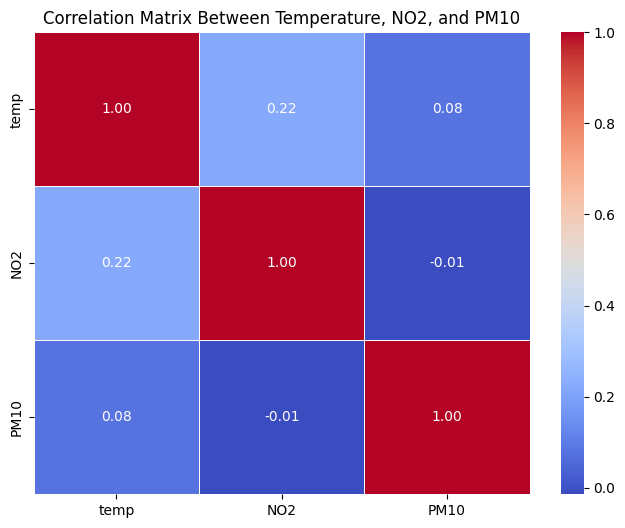

In [53]:
corr_cols = ['NO2', 'PM10', 'temp']
corr = df_combined[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between Temperature, NO2, and PM10")
plt.show()

It appears there is no correlation between the overall temperature and the pollutants in the air.

<!-- estimate how big a city is based on no2,
data that has district/coords, get min/max value coords for the districts. polygon for each district.  -->